In [86]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [87]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
np.random.seed(123)  # For reproducibility

In [88]:
annotation = pd.read_csv("Data/annotations.csv")

In [89]:
annotation

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115,rbc
2336,image-69.png,201.832018,211.930101,251.736189,256.000000,rbc
2337,image-69.png,81.188275,231.883878,130.855693,254.391206,rbc
2338,image-69.png,35.903044,244.555806,79.863585,255.066516,rbc


### SSD Model

We adopted the Single Shot Multibox Detection as the second model.

It is a multiscale object detection model, and mainly consists of a base network followed by several multiscale feature map blocks. Via its base network and several multiscale feature map blocks, single-shot multibox detection generates a varying number of anchor boxes with different sizes, and detects varying-size objects by predicting classes and offsets of these anchor boxes (bounding boxes).

In [90]:
# Class prediction layer
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [91]:
# Bounding box prediction layer
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3,
                     padding=1)

In [92]:
# Concatenating predictions for multiple scales
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [93]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [94]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [95]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [96]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [97]:
# Base network block
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [98]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [99]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [100]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [101]:
# The complete model
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [102]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


### Train the model

1. Initialize the model and set up the dataset

In [29]:
annotation

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115,rbc
2336,image-69.png,201.832018,211.930101,251.736189,256.000000,rbc
2337,image-69.png,81.188275,231.883878,130.855693,254.391206,rbc
2338,image-69.png,35.903044,244.555806,79.863585,255.066516,rbc


In [33]:
train_annotation = annotation.sample(frac=0.9,random_state=200)
train_annotation

,image,xmin,ymin,xmax,ymax,label
2103,image-22.png,147.809470,0.000000,204.306652,29.210823,rbc
1523,image-50.png,18.414882,72.608794,63.833145,123.124014,rbc
495,image-18.png,0.000000,0.000000,62.144307,32.889515,rbc
782,image-94.png,37.096956,189.616685,92.545660,243.367531,rbc
1901,image-34.png,29.170237,9.677565,82.161218,62.935738,rbc
...,...,...,...,...,...,...
227,image-11.png,5.777130,50.317386,60.395566,102.843641,rbc
1678,image-45.png,140.843292,94.177001,201.270575,147.250282,rbc
1471,image-62.png,93.304397,217.148816,145.109357,256.000000,rbc
1990,image-21.png,29.957159,126.465614,89.723788,181.921082,rbc


In [32]:
test_annotation = annotation.drop(train_annotation.index)
test_annotation

,image,xmin,ymin,xmax,ymax,label
17,image-100.png,171.982497,118.891482,233.199533,180.308051,rbc
18,image-100.png,204.196033,113.086348,253.541424,168.856476,rbc
67,image-102.png,90.663944,201.045508,148.256709,255.456243,rbc
89,image-1.png,85.610268,2.334889,187.738623,120.068845,wbc
90,image-1.png,85.610268,2.334889,187.738623,120.068845,rbc
...,...,...,...,...,...,...
2285,image-33.png,90.746336,135.036077,183.062007,228.898534,wbc
2312,image-69.png,21.604284,22.341601,83.162345,75.508455,rbc
2314,image-69.png,148.996618,36.496054,193.899662,89.798196,rbc
2318,image-69.png,23.996618,51.090192,82.605411,108.246900,rbc


In [53]:
train_iter, _ = train_annotation, test_annotation

In [54]:
device, net = d2l.try_gpu(), TinySSD(num_classes=2)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

2. Define the loss and evaluation functions. The loss function is calculated based on the predicted and labeled values of the anchor box classes and offsets.

In [55]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [56]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

3. Train the model

In [85]:
num_epochs, timer = 50, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

/opt/anaconda3/lib/python3.7/site-packages/d2l/torch.py:317: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)


ValueError: too many values to unpack (expected 2)

4. Predict

(256, 256, 3)


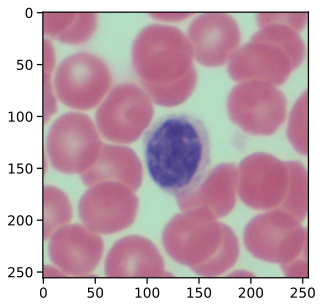

In [44]:
# read a sample image
import cv2
image = cv2.imread('Data/images/image-20.png')
image = image[:,:,2::-1]
print(image.shape)
plt.imshow(image)
plt.show()

In [45]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

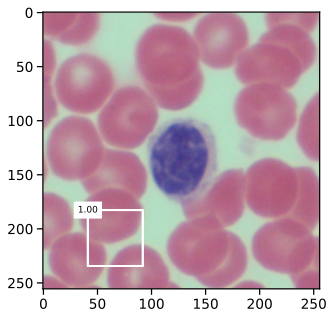

In [48]:
def display(image, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(image)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = image.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(image, output.cpu(), threshold=0.9)
plt.show()